In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")


In [3]:
sentiment['date'] = pd.to_datetime(sentiment['date'])

In [4]:
def map_binary_sentiment(label):
    if label in ['Extreme Fear', 'Fear']:
        return 0
    elif label in ['Greed', 'Extreme Greed']:
        return 1
    else:
        return np.nan  # Drop Neutral

sentiment['Binary_Sentiment'] = sentiment['classification'].apply(map_binary_sentiment)

In [5]:
sentiment_map = {
    'Extreme Fear': 0,
    'Fear': 1,
    'Neutral': 2,
    'Greed': 3,
    'Extreme Greed': 4
}
sentiment['Sentiment_Score'] = sentiment['classification'].map(sentiment_map)

In [6]:
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], errors='coerce')
trades['Date'] = trades['Timestamp IST'].dt.date
trades['Closed PnL'] = pd.to_numeric(trades['Closed PnL'], errors='coerce')
trades['Side'] = trades['Side'].str.strip()

In [7]:
agg = trades.groupby('Date').agg({
    'Closed PnL': ['mean', 'sum', 'std'],
    'Side': lambda x: (x == 'Buy').sum() / len(x),
    'Account': 'nunique'
}).reset_index()

In [8]:
agg.columns = ['Date', 'avg_PnL', 'total_PnL', 'std_PnL', 'long_ratio', 'unique_accounts']
agg['Date'] = pd.to_datetime(agg['Date'])

In [9]:
sentiment_binary = sentiment.dropna(subset=['Binary_Sentiment'])
merged_binary = pd.merge(agg, sentiment_binary[['date', 'Binary_Sentiment']], left_on='Date', right_on='date')


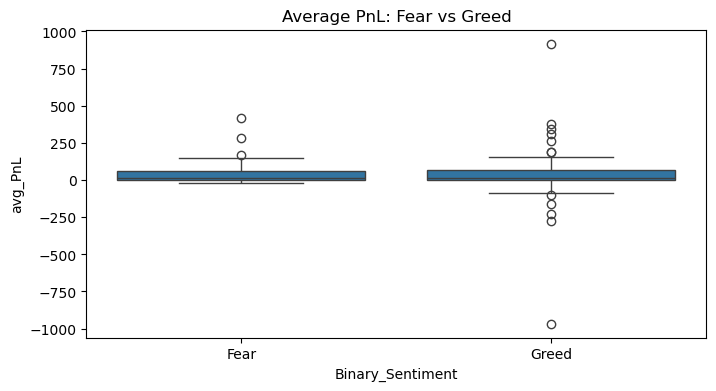

In [10]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=merged_binary, x='Binary_Sentiment', y='avg_PnL')
plt.xticks([0, 1], ['Fear', 'Greed'])
plt.title('Average PnL: Fear vs Greed')
plt.show()

In [11]:
fear_pnl = merged_binary[merged_binary['Binary_Sentiment'] == 0]['avg_PnL']
greed_pnl = merged_binary[merged_binary['Binary_Sentiment'] == 1]['avg_PnL']
t_stat, p_val = ttest_ind(fear_pnl, greed_pnl, nan_policy='omit')
print(f"T-test (Avg PnL): T={t_stat:.2f}, p-value={p_val:.4f}")

T-test (Avg PnL): T=0.49, p-value=0.6228


In [12]:
merged_full = pd.merge(agg, sentiment[['date', 'Sentiment_Score']], left_on='Date', right_on='date')


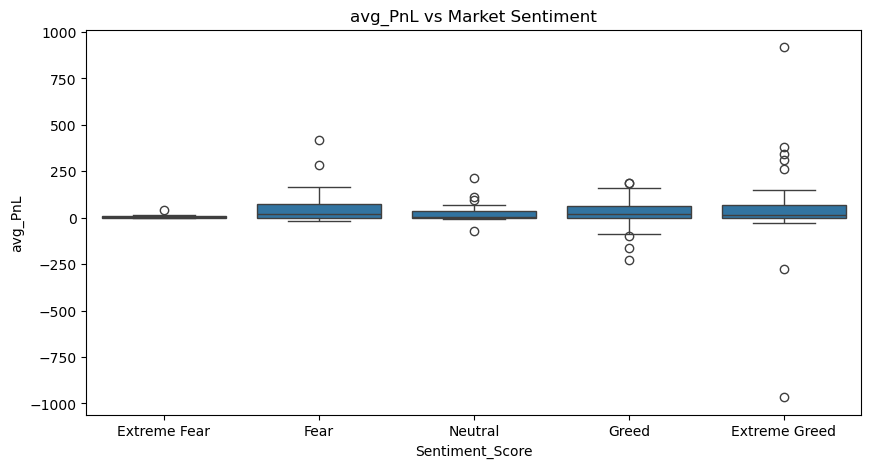

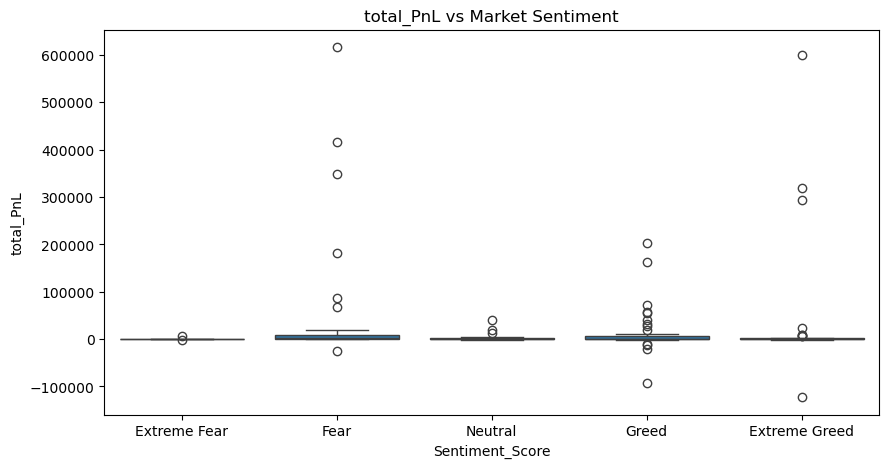

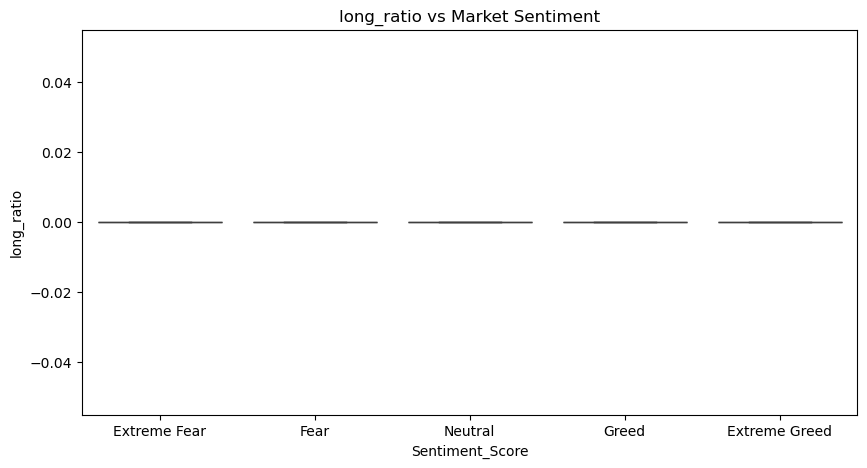

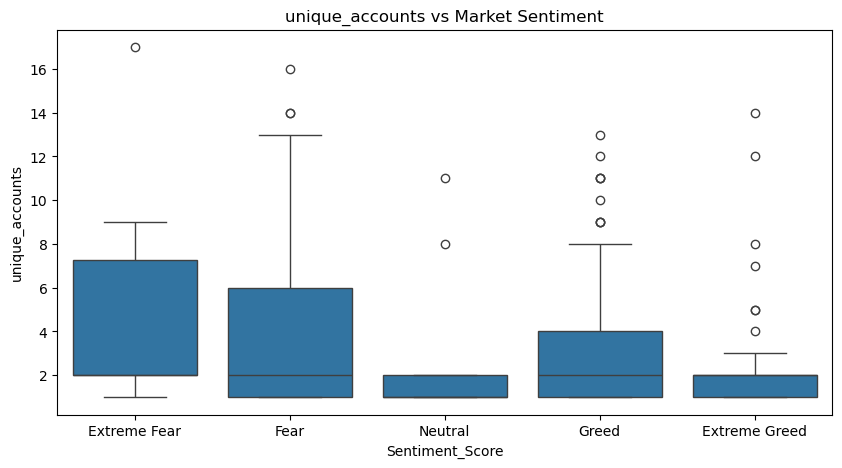

In [13]:
labels = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
for col in ['avg_PnL', 'total_PnL', 'long_ratio', 'unique_accounts']:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=merged_full, x='Sentiment_Score', y=col)
    plt.xticks([0, 1, 2, 3, 4], labels)
    plt.title(f'{col} vs Market Sentiment')
    plt.show()

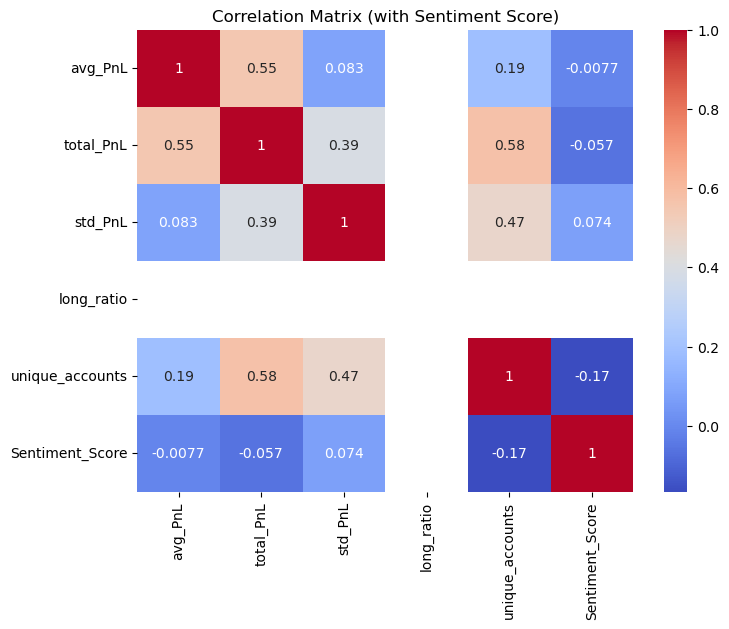

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(merged_full.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (with Sentiment Score)')
plt.show()

In [15]:
X = merged_full[['Sentiment_Score']]
y = merged_full['avg_PnL']
reg = LinearRegression().fit(X, y)
print(f"Linear Regression: avg_PnL = {reg.coef_[0]:.3f} * Sentiment + {reg.intercept_:.3f}")


Linear Regression: avg_PnL = -0.860 * Sentiment + 41.694


In [16]:
rho, p = spearmanr(merged_full['Sentiment_Score'], merged_full['avg_PnL'])
print(f"Spearman Correlation (avg_PnL ~ Sentiment): rho={rho:.3f}, p={p:.4f}")


Spearman Correlation (avg_PnL ~ Sentiment): rho=0.049, p=0.5428


In [17]:
def classify_sentiment(score):
    if score <= 1:
        return 0  # Fear
    elif score == 2:
        return 1  # Neutral
    else:
        return 2  # Greed

In [18]:
merged_full['Sentiment_Class'] = merged_full['Sentiment_Score'].apply(classify_sentiment)


In [19]:
features = ['avg_PnL', 'total_PnL', 'long_ratio', 'unique_accounts']
X = merged_full[features]
y = merged_full['Sentiment_Class']


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [21]:
print("\nClassification Report (Sentiment Class - Fear, Neutral, Greed):")
print(classification_report(y_test, y_pred))


Classification Report (Sentiment Class - Fear, Neutral, Greed):
              precision    recall  f1-score   support

           0       0.17      0.08      0.11        13
           1       0.00      0.00      0.00         3
           2       0.61      0.72      0.66        32

    accuracy                           0.50        48
   macro avg       0.26      0.27      0.25        48
weighted avg       0.45      0.50      0.47        48

